<a href="https://colab.research.google.com/github/Parikshit07111996/School-Of-AI/blob/master/Assignment_S7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%matplotlib inline

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np

import torch.nn as nn
import torch.nn.functional as F

!pip install torchsummary
from torchsummary import summary
import torch.optim as optim
from tqdm import tqdm

In [0]:
class BatchNorm(nn.BatchNorm2d):
    def __init__(self, num_features, eps=1e-05, momentum=0.1, weight=True, bias=True):
        super().__init__(num_features, eps=eps, momentum=momentum)
        self.weight.data.fill_(1.0)
        self.bias.data.fill_(0.0)
        self.weight.requires_grad = weight
        self.bias.requires_grad = bias


class GhostBatchNorm(BatchNorm):
    def __init__(self, num_features, num_splits, **kw):
        super().__init__(num_features, **kw)
        self.num_splits = num_splits
        self.register_buffer('running_mean', torch.zeros(num_features * self.num_splits))
        self.register_buffer('running_var', torch.ones(num_features * self.num_splits))

    def train(self, mode=True):
        if (self.training is True) and (mode is False):  # lazily collate stats when we are going to use them
            self.running_mean = torch.mean(self.running_mean.view(self.num_splits, self.num_features), dim=0).repeat(
                self.num_splits)
            self.running_var = torch.mean(self.running_var.view(self.num_splits, self.num_features), dim=0).repeat(
                self.num_splits)
        return super().train(mode)

    def forward(self, input):
        N, C, H, W = input.shape
        if self.training or not self.track_running_stats:
            return F.batch_norm(
                input.view(-1, C * self.num_splits, H, W), self.running_mean, self.running_var,
                self.weight.repeat(self.num_splits), self.bias.repeat(self.num_splits),
                True, self.momentum, self.eps).view(N, C, H, W)
        else:
            return F.batch_norm(
                input, self.running_mean[:self.num_features], self.running_var[:self.num_features],
                self.weight, self.bias, False, self.momentum, self.eps)

In [0]:
def getDevice():
  use_cuda = torch.cuda.is_available()
  device = torch.device("cuda" if use_cuda else "cpu")
  return device

def getDataLoaderArgs(batchSize):
  BATCH_SIZE = batchSize
  SEED = 1

  # CUDA?
  cuda = torch.cuda.is_available()
  print("CUDA Available?", cuda)

  # For reproducibility
  torch.manual_seed(SEED)

  if cuda:
      torch.cuda.manual_seed(SEED)

  # dataloader arguments - something you'll fetch these from cmdprmt
  dataloader_args = dict(shuffle=True, batch_size=BATCH_SIZE, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)
  return dataloader_args

def getTrainDataLoader(dataloader_args):
  transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

  trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
  trainloader = torch.utils.data.DataLoader(trainset, **dataloader_args)
  return trainloader

def getTestDataLoader(dataloader_args):
  transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
  testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
  testloader = torch.utils.data.DataLoader(testset, **dataloader_args)
  return testloader

def getModel(device):
  model = Net().to(device)
  return model

def getModelSummary(model):
  summary(model, input_size=(3, 32, 32))

def getOptimizer(model, lr=0.001, weight_decay=0):
  optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=weight_decay)
  return optimizer

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

In [0]:
train_losses = []
train_acc = []
def train(model, device, train_loader, optimizer, l1_factor=0):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    criterion = nn.CrossEntropyLoss()
    loss = criterion(y_pred, target)
    if l1_factor:
      loss = L1_Loss(model, loss)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)
  
def test(net, testloader, device):
  correct = 0
  total = 0
  with torch.no_grad():
      for data in testloader:
          images, labels = data
          images, labels = images.to(device), labels.to(device)
          outputs = net(images)
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()

  print('Accuracy of the network on the 10000 test images: %d %%' % (
      100 * correct / total))
  
def class_performance(net, testloader, device):
  class_correct = list(0. for i in range(10))
  class_total = list(0. for i in range(10))
  with torch.no_grad():
      for data in testloader:
          images, labels = data
          images, labels = images.to(device), labels.to(device)
          outputs = net(images)
          _, predicted = torch.max(outputs, 1)
          c = (predicted == labels).squeeze()
          for i in range(4):
              label = labels[i]
              class_correct[label] += c[i].item()
              class_total[label] += 1


  for i in range(10):
      print('Accuracy of %5s : %2d %%' % (
          classes[i], 100 * class_correct[i] / class_total[i]))
      
def predict_on_test(net, testloader, device ):
  dataiter = iter(testloader)
  images, labels = dataiter.next()
  images, labels = images.to(device), labels.to(device)
  # print images
  imshow(torchvision.utils.make_grid(images.cpu()))
  print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(64)))
  # print('GroundTruth: ', '%5s' % classes[labels])
  outputs = net(images)
  _, predicted = torch.max(outputs, 1)
  print('Predicted: ', '%5s' % ' '.join('%5s' % classes[predicted[j]] for j in range(64)))

In [0]:
dropout_value = 0.1
num_splits = 2 
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        # CONVOLUTION BLOCK 1
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=(3, 3), padding=1, bias=False), #RF = 3
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout(dropout_value),

            # Dilated Convolution
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), padding=2, bias=False, dilation=2), #RF = 7
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Dropout(dropout_value),

            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3, 3), padding=1, bias=False), #RF = 9 
            nn.ReLU(),
            GhostBatchNorm(128, num_splits),
            nn.Dropout(dropout_value),

            nn.Conv2d(in_channels=128, out_channels=32, kernel_size=(1, 1), padding=0, bias=False), #RF = 9
            nn.ReLU()

        ) # output_size = 32

        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 16 RF = 10

        # CONVOLUTION BLOCK 2
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), padding=1, bias=False), #RF = 14
            nn.ReLU(),
            # GhostBatchNorm(64, num_splits),
            nn.BatchNorm2d(64),
            nn.Dropout(dropout_value),

            # Depthwise separable convolution
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3, 3), padding=1, bias=False, groups=64), #RF = 18
            nn.ReLU(),
            # GhostBatchNorm(64, num_splits), 
            nn.BatchNorm2d(64),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(1, 1), padding=0, bias=False), #RF = 18
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Dropout(dropout_value),

            nn.Conv2d(in_channels=128, out_channels=32, kernel_size=(1, 1), padding=0, bias=False), #RF = 18
            nn.ReLU()
        ) # output_size = 16
        

        self.pool2 = nn.MaxPool2d(2, 2) # output_size = 8 RF = 20

        # CONVOLUTION BLOCK 3
        self.convblock3 = nn.Sequential( 
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), padding=1, bias=False), #RF = 28
            nn.ReLU(),
            # GhostBatchNorm(64, num_splits),
            nn.BatchNorm2d(64),
            nn.Dropout(dropout_value),

            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3, 3), padding=1, bias=False), #RF = 36
            nn.ReLU(),
            # GhostBatchNorm(128, num_splits),
            nn.BatchNorm2d(128),
            nn.Dropout(dropout_value),

            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=(3, 3), padding=1, bias=False), #RF = 36
            nn.ReLU(),
            # GhostBatchNorm(256, num_splits),
            nn.BatchNorm2d(256),
            nn.Dropout(dropout_value),

            nn.Conv2d(in_channels=256, out_channels=32, kernel_size=(1, 1), padding=0, bias=False), #RF = 36
            nn.ReLU()
        ) # output_size = 8

        self.pool3 = nn.MaxPool2d(2, 2) # output_size = 4 RF = 40

        # CONVOLUTION BLOCK 4
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), padding=1, bias=False), #RF = 56
            nn.ReLU(),
            # GhostBatchNorm(64, num_splits),
            nn.BatchNorm2d(64),
            nn.Dropout(dropout_value),

            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3, 3), padding=1, bias=False), #RF = 72
            nn.ReLU(),
            # GhostBatchNorm(128, num_splits),
            nn.BatchNorm2d(128),
            nn.Dropout(dropout_value),

            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=(3, 3), padding=1, bias=False), #RF = 72
            nn.ReLU(),
            # GhostBatchNorm(256, num_splits),
            nn.BatchNorm2d(256),
            nn.Dropout(dropout_value),

            # nn.Conv2d(in_channels=256, out_channels=64, kernel_size=(1, 1), padding=0, bias=False), #RF = 72
            # nn.ReLU(),
            # nn.Dropout(dropout_value),

        ) # output_size = 4


        # OUTPUT BLOCK
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=4)
        ) # output_size = 1 RF = 96
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=10, kernel_size=(1, 1), padding=0, bias=False), #RF = 
        ) # output_size = 1 RF = 96

        # self.fc1 = nn.Linear(1, 10) # output_size = 1



    def forward(self, x):
        x = self.convblock1(x)
        x = self.pool1(x)
        x = self.convblock2(x)
        x = self.pool2(x)
        x = self.convblock3(x)
        x = self.pool3(x)
        x = self.convblock4(x)
        x = self.gap(x)
        x = self.convblock5(x)
        # x = self.fc1(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

In [6]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
device = getDevice()
dataloader_args = getDataLoaderArgs(64)
trainloader = getTrainDataLoader(dataloader_args)
net = getModel(device)
summary = getModelSummary(net)
optimizer = getOptimizer(net)

CUDA Available? True


Extracting ./data/cifar-10-python.tar.gz to ./data
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             864
              ReLU-2           [-1, 32, 32, 32]               0
       BatchNorm2d-3           [-1, 32, 32, 32]              64
           Dropout-4           [-1, 32, 32, 32]               0
            Conv2d-5           [-1, 64, 32, 32]          18,432
              ReLU-6           [-1, 64, 32, 32]               0
       BatchNorm2d-7           [-1, 64, 32, 32]             128
           Dropout-8           [-1, 64, 32, 32]               0
            Conv2d-9          [-1, 128, 32, 32]          73,728
             ReLU-10          [-1, 128, 32, 32]               0
   GhostBatchNorm-11          [-1, 128, 32, 32]             256
          Dropout-12          [-1, 128, 32, 32]               0
           Conv2d-13           [-1, 32, 32, 32]     

In [7]:
for epoch in range(25):
  train(net, device, trainloader,optimizer)

Loss=1.1443747282028198 Batch_id=781 Accuracy=39.07: 100%|██████████| 782/782 [00:36<00:00, 21.64it/s]
Loss=1.7730416059494019 Batch_id=781 Accuracy=54.42: 100%|██████████| 782/782 [00:36<00:00, 21.38it/s]
Loss=0.9120876789093018 Batch_id=781 Accuracy=62.16: 100%|██████████| 782/782 [00:36<00:00, 21.66it/s]
Loss=1.0970017910003662 Batch_id=781 Accuracy=67.46: 100%|██████████| 782/782 [00:36<00:00, 21.42it/s]
Loss=0.41632360219955444 Batch_id=781 Accuracy=70.80: 100%|██████████| 782/782 [00:36<00:00, 21.29it/s]
Loss=0.8189821243286133 Batch_id=781 Accuracy=73.42: 100%|██████████| 782/782 [00:36<00:00, 21.36it/s]
Loss=0.7417314648628235 Batch_id=781 Accuracy=75.32: 100%|██████████| 782/782 [00:36<00:00, 21.22it/s]
Loss=0.5260855555534363 Batch_id=781 Accuracy=77.39: 100%|██████████| 782/782 [00:36<00:00, 21.44it/s]
Loss=1.0387974977493286 Batch_id=781 Accuracy=78.60: 100%|██████████| 782/782 [00:36<00:00, 21.30it/s]
Loss=0.8434754610061646 Batch_id=781 Accuracy=79.97: 100%|██████████| 78

Okay, now let us see what the neural network thinks these examples above are:



Files already downloaded and verified
GroundTruth:    cat  frog  deer  ship  frog  deer   car  ship  frog   cat horse plane  deer  frog   car plane  ship  bird plane truck   cat  frog  frog  deer truck   car plane horse   cat  bird plane plane   cat  ship  deer   cat truck horse truck  ship  bird truck truck  deer   car  ship   cat plane   dog   car  deer  deer  bird truck truck   cat truck horse   cat  frog horse   car   car plane
Predicted:    cat  frog   cat  ship  frog   cat  frog  ship  frog   dog horse plane  deer  frog   car plane  ship  bird plane truck   cat  bird  frog  deer truck   car plane horse   dog  bird plane plane   dog  ship  deer  frog truck horse truck  ship  bird truck truck horse   car  ship  bird plane   dog   car  deer  deer  bird truck truck  frog truck horse   cat  frog horse   car   car  bird
Accuracy of the network on the 10000 test images: 80 %
Accuracy of plane : 77 %
Accuracy of   car : 91 %
Accuracy of  bird : 69 %
Accuracy of   cat : 66 %
Accuracy of  

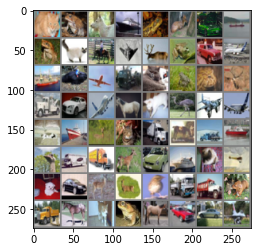

In [8]:
testloader = getTestDataLoader(dataloader_args)
predict_on_test(net, testloader, device)
test(net, testloader, device)
class_performance(net, testloader, device)